## Random Forest
```html
Random forest generates Decision trees on bootstraped data
Bootstraping is shafling the original dataset, so Decision trees in forest will be randoml


```

In [57]:
# Basic imports

import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import random
from IPython.core.display import display,Image
from string import Template
import IPython.display
import warnings

In [58]:
from collections import Counter

def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return(-np.sum([p * np.log2(p) for p in ps if p>0]))

            
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
  
    def is_leaf_node(self):
        return(self.value is not None)


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        #stopping criteria
        if(depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return(Node(value=leaf_value))
    
        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        #greedy search
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        left_idxs, right_idxs = self._split(X[:,best_feat],best_thresh)

        left = self._grow_tree(X[left_idxs,:], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs,:], y[right_idxs], depth+1)
        return(Node(best_feat, best_thresh, left, right))
  

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                if(gain>best_gain):
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold
        return(split_idx, split_thresh)

    def _information_gain(self, y, X_column, split_threh):
        #parent entropy
        parent_entropy = entropy(y)

        #generate split
        left_idxs, right_idxs = self._split(X_column, split_threh)
        if(len(left_idxs == 0) or len(right_idxs)==0):
            return 0

        #weighted avg vhild entropy
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l/n)*e_l + (n_r/n)*e_r

        #return ig
        ig = parent_entropy - child_entropy

        return ig
  
    def _split(self, X_column, split_threh):
        left_idxs = np.argwhere(X_column <= split_threh).flatten()
        right_idxs = np.argwhere(X_column > split_threh).flatten()
        return(left_idxs, right_idxs)
  
    def predict(self, X):
        #traverse tree
        return(np.array([self._traverse_tree(x, self.root) for x in X]))

    def _traverse_tree(self, x, node):
        if(node.is_leaf_node()):
            return(node.value)

        if(x[node.feature] <= node.threshold):
            return(self._traverse_tree(x, node.left))
        return(self._traverse_tree(x, node.right))

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return(most_common)

In [61]:
def bootstrap(X, y):
    n_samples = X.shape[0]
    # create list of random indexes that can be repeated and return X and y with these indexes
    indexes = np.random.choice(n_samples, size=n_samples, replace=True)
    return X[indexes], y[indexes]


# most common value in y array
def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common


class RandomForest:
    
    def __init__(self, n_trees=100, min_samples_split=2, max_depth=10, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []
    
    # create n_trees DecisionTrees and fit each on bootstrapped datasets
    def fit(self, X, y):
        self.trees = []
        for i in range(self.n_trees):
            tree = DecisionTree(min_samples_split=self.min_samples_split,
                                max_depth=self.max_depth, n_feats=self.n_feats)
            X_sample, y_sample = bootstrap(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
    
    # predict for each tree and take most commom answer
    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees]).T
        y_preds = np.array([most_common_label(row) for row in tree_preds])
        return y_preds

In [63]:
# test Random Forest


def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return(accuracy)


data = datasets.load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

clf_f = RandomForest(n_trees=20, min_samples_split=2, max_depth=5)
clf_f.fit(X_train, y_train)

y_pred = clf_f.predict(X_test)
acc = accuracy(y_test, y_pred)

print("Accuracy: ",acc)

Accuracy:  0.6228070175438597


<AxesSubplot:>

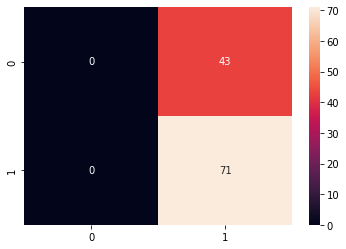

In [64]:
cnf_matrix = confusion_matrix(y_test, y_pred)
import seaborn as sns
sns.heatmap(cnf_matrix, annot=True)